In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## **第一步：数据加载与初步探索分析**

In [1]:
import pandas as pd
df = pd.read_csv('/kaggle/input/ecommerce-product-recommendation-collaborative/user_personalized_features.csv')

df=df.copy()
df.drop(['Unnamed: 0'], axis=1, inplace=True)

df.head(10)

,User_ID,Age,Gender,Location,Income,Interests,Last_Login_Days_Ago,Purchase_Frequency,Average_Order_Value,Total_Spending,Product_Category_Preference,Time_Spent_on_Site_Minutes,Pages_Viewed,Newsletter_Subscription
0,#1,56,Male,Suburban,38037,Sports,5,7,18,2546,Books,584,38,True
1,#2,46,Female,Rural,103986,Technology,15,7,118,320,Electronics,432,40,False
2,#3,32,Female,Suburban,101942,Sports,28,1,146,3766,Apparel,306,1,True
3,#4,60,Female,Suburban,71612,Fashion,18,3,163,4377,Apparel,527,29,False
4,#5,25,Male,Suburban,49725,Travel,2,5,141,4502,Health & Beauty,53,10,True
5,#6,38,Male,Suburban,25926,Travel,22,8,25,2669,Books,520,28,False
6,#7,56,Male,Urban,124555,Fashion,11,7,152,1113,Home & Kitchen,330,31,True
7,#8,36,Male,Urban,29496,Technology,26,7,108,2151,Apparel,558,19,True
8,#9,40,Male,Rural,76447,Travel,25,6,130,4085,Books,325,3,True
9,#10,28,Male,Urban,121604,Food,13,8,61,4999,Electronics,114,36,False


In [2]:
# 查看数据的基本信息
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   User_ID                      1000 non-null   object
 1   Age                          1000 non-null   int64 
 2   Gender                       1000 non-null   object
 3   Location                     1000 non-null   object
 4   Income                       1000 non-null   int64 
 5   Interests                    1000 non-null   object
 6   Last_Login_Days_Ago          1000 non-null   int64 
 7   Purchase_Frequency           1000 non-null   int64 
 8   Average_Order_Value          1000 non-null   int64 
 9   Total_Spending               1000 non-null   int64 
 10  Product_Category_Preference  1000 non-null   object
 11  Time_Spent_on_Site_Minutes   1000 non-null   int64 
 12  Pages_Viewed                 1000 non-null   int64 
 13  Newsletter_Subscription      1000 

In [3]:
# 检查缺失值
missing_values = df.isnull().sum()
print("各列缺失值数量：\n", missing_values)

各列缺失值数量：
 User_ID                        0
Age                            0
Gender                         0
Location                       0
Income                         0
Interests                      0
Last_Login_Days_Ago            0
Purchase_Frequency             0
Average_Order_Value            0
Total_Spending                 0
Product_Category_Preference    0
Time_Spent_on_Site_Minutes     0
Pages_Viewed                   0
Newsletter_Subscription        0
dtype: int64


### 可以看到数据由8个数值变量，5个类别变量，一个bool变量组成，均无缺失值，下面对于关键字段进行初步可视化分析

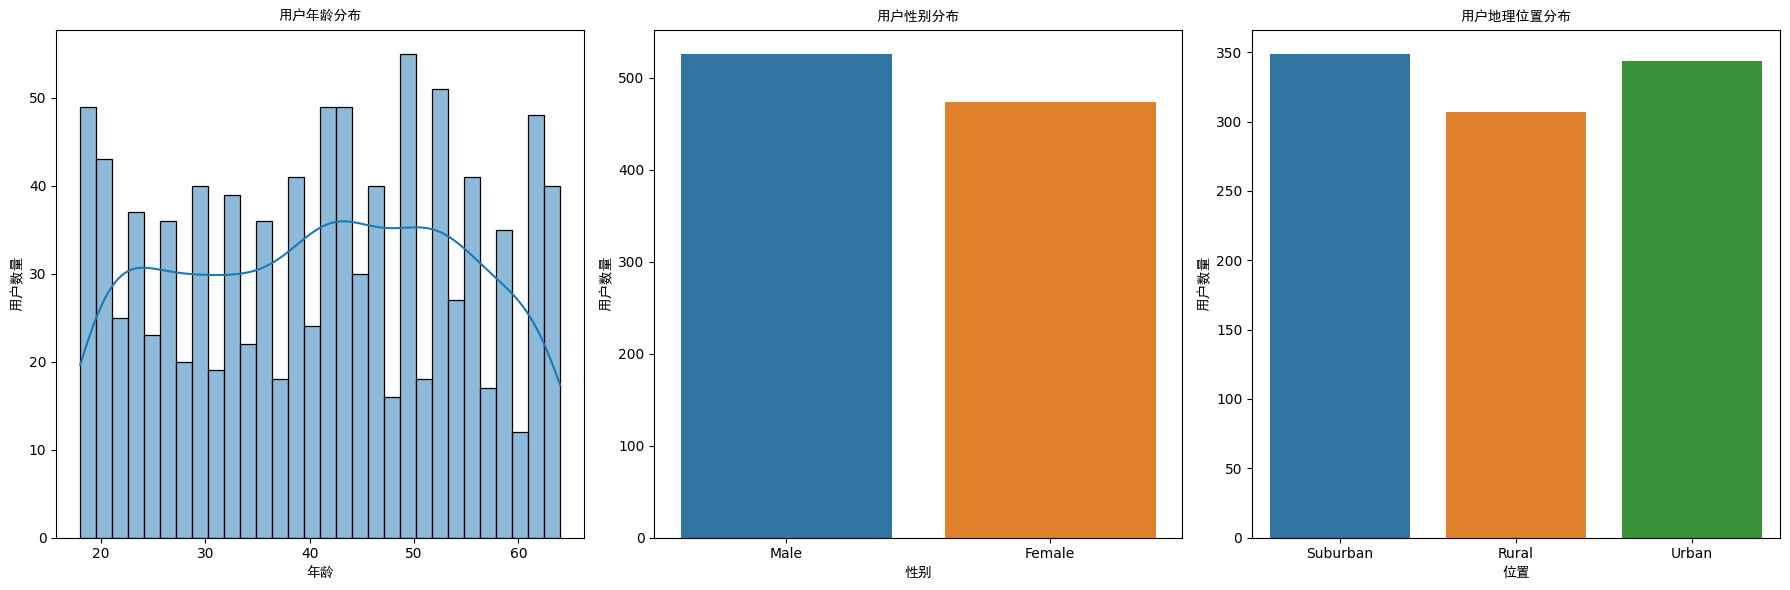

In [4]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# 设置字体路径
font_path = "/kaggle/input/simhei/SIMHEI.TTF"  # 字体文件路径
my_font = fm.FontProperties(fname=font_path)

# 创建一个 1 行 3 列的子图布局
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 调整整体布局大小

# 第一个子图：年龄分布
sns.histplot(df['Age'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('用户年龄分布', fontproperties=my_font)
axes[0].set_xlabel('年龄', fontproperties=my_font)
axes[0].set_ylabel('用户数量', fontproperties=my_font)

# 第二个子图：性别分布
sns.countplot(x='Gender', data=df, ax=axes[1])
axes[1].set_title('用户性别分布', fontproperties=my_font)
axes[1].set_xlabel('性别', fontproperties=my_font)
axes[1].set_ylabel('用户数量', fontproperties=my_font)

# 第三个子图：地理位置分布
sns.countplot(x='Location', data=df, ax=axes[2])
axes[2].set_title('用户地理位置分布', fontproperties=my_font)
axes[2].set_xlabel('位置', fontproperties=my_font)
axes[2].set_ylabel('用户数量', fontproperties=my_font)

# 调整子图之间的间距
plt.tight_layout()
plt.show()

## 第二步：RFM用户分层
在电商场景中，由于“高价值”和“低价值”用户的行为模式和商机价值不同，因此需要先基于RFM模型（Recency，Frequency，Monetary）对用户进行分层，再针对不同分层分别定义流失标准：高价值用户 7 天无登录为流失，低价值用户 14 天无登录为流失。以下为详细分层步骤。

### 2.1 计算 RFM 指标
#### 2.1.1 数据准备
- Recency（R）：从数据集最新日期（如今日）到用户最后一次购买或登录的天数。

- Frequency（F）：在指定周期内（如过去 1 年）用户的购买次数。

- Monetary（M）：同一周期内用户的总消费金额。

RFM 是一种成熟的电商客户分层技术，能够帮助品牌区分高、中、低价值用户

这里使用'Last_Login_Days_Ago', 'Purchase_Frequency', 'Total_Spending'分别作为 Recency（R），Frequency（F），Monetary（M）的代表。

In [5]:
# 构建 RFM dataframe
rfm = df[['User_ID', 'Last_Login_Days_Ago', 'Purchase_Frequency', 'Total_Spending']].copy()
rfm.rename(columns={
    'Last_Login_Days_Ago': 'Recency',
    'Purchase_Frequency': 'Frequency',
    'Total_Spending': 'Monetary'
}, inplace=True)

### 2.2 对每个指标打分
通常将每个指标按分位数或业务自定义阈值划分成 1–5 分段：

- Recency：最近购买越近分数越高；

- Frequency：购买次数越多分数越高；

- Monetary：消费金额越高分数越高。


In [6]:
# 给 Recency/Frequency/Monetary 分段打分
# 这里 Recency 越小越好，所以打分时要反过来（小天数对应高分）
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'], 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

### 2.3 划分高/低价值用户
#### 2.3.1 自定义阈值
高价值用户：RFM_Score ≥12（如 top 20%）。

低价值用户：RFM_Score ≤6（如 bottom 20%）。

中价值用户：其余用户。

RFM 分层可帮助挖掘关键待挽回人群，转化率通常是普通策略的 2–3 倍​
MoEngage
。

In [7]:
# 计算总的 RFM 得分
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].astype(int).sum(axis=1)

# 划分高/中/低价值用户
high_thresh = rfm['RFM_Score'].quantile(0.8)  # top 20%
low_thresh  = rfm['RFM_Score'].quantile(0.2)  # bottom 20%

rfm['Customer_Value_Segment'] = rfm['RFM_Score'].apply(
    lambda x: 'High' if x >= high_thresh else ('Low' if x <= low_thresh else 'Mid')
)

### 2.4 基于分层定义流失标签
- 高价值：Last_Login_Days_Ago > 7 → Churn_Label = 1，否则 0。

- 低/中价值：Last_Login_Days_Ago > 14 → Churn_Label = 1，否则 0。

针对不同价值等级采用差异化流失标准，可更精确捕捉流失风险并优化营销资源分配

In [8]:
#df = df.drop(['Customer_Value_Segment_y', 'Customer_Value_Segment_x'], axis=1)
# 合并回原 df
df = df.merge(rfm[['User_ID', 'Customer_Value_Segment']], on='User_ID', how='left')

In [9]:
# 按不同用户分层定义流失标准
def label_churn(row):
    if row['Customer_Value_Segment'] == 'High':
        return int(row['Last_Login_Days_Ago'] > 7)
    else:
        return int(row['Last_Login_Days_Ago'] > 14)

df['Churn_Label'] = df.apply(label_churn, axis=1)

# 删除泄漏字段
df = df.drop(columns=['Last_Login_Days_Ago'])  # Recency 只是个中间变量


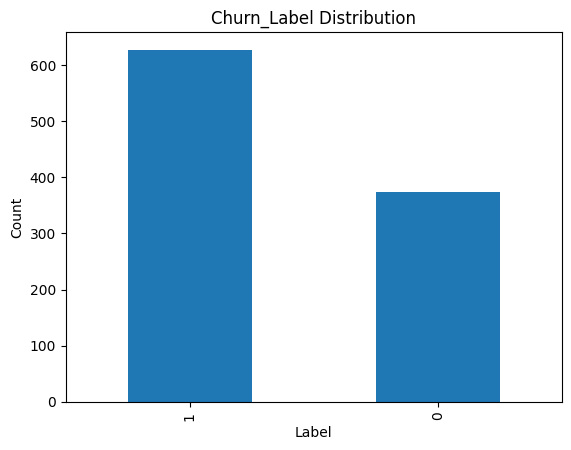

In [10]:
import matplotlib.pyplot as plt

# 绘制条形图
df['Churn_Label'].value_counts().plot(kind='bar')
plt.title('Churn_Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

## 第三步：特征工程与流失标签构建
## 3.1 特征工程
我针对数据构建了以下特征用于建模：

- 人口统计特征：Age, Gender, Location, Income

- 行为特征：Purchase_Frequency, Average_Order_Value, Total_Spending, Time_Spent_on_Site_Minutes, Pages_Viewed​

- 兴趣特征：Interests, Product_Category_Preference

- 订阅特征：Newsletter_Subscription

**定义预处理函数和管道：**

In [11]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# 定义数值特征和类别特征
numeric_features = ['Age', 'Income', 'Purchase_Frequency', 'Average_Order_Value',
                    'Total_Spending', 'Time_Spent_on_Site_Minutes', 'Pages_Viewed']
categorical_features = ['Gender', 'Location', 'Interests', 'Product_Category_Preference', 'Newsletter_Subscription']

# 数值特征的预处理，这里在数据探索的时候无缺失值所以无需处理，这里展示一个缺失值处理工具SimpleImputer
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])

# 类别特征的预处理：填充缺失值并进行独热编码，常规数据通常存在缺失值，写上对应预处理步骤，增强代码复用性，但本数据可无需处理缺失
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# 创建预处理器
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


## 第四步：建模与评估
### 4.1 数据集划分
按帕累托原则，80%的数据用于训练，20%用于测试。

In [12]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['User_ID','Churn_Label'])  
y = df['Churn_Label'] 

# 先划分训练+验证和测试，stratify=y（保持类别比例）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


print(f"训练集大小: {len(X_train)}")
print(f"测试集大小: {len(X_test)}")


训练集大小: 800
测试集大小: 200


### 4.2 模型选择与训练
#### 4.2.1 下采样
首先由于未流失的用户数据量少，首先对未流失的用户数据进行下采样，平衡样本数量

In [13]:
import pandas as pd
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# 先在训练集上 fit_transform，测试集上 transform
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# 合并预处理后的特征和标签（方便上采样）
train_df = pd.DataFrame(X_train_preprocessed)
train_df['Churn_Label'] = y_train.values

# 分离多数类和少数类
df_majority = train_df[train_df.Churn_Label == 1]
df_minority = train_df[train_df.Churn_Label == 0]

# 上采样少数类
df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

# 合并上采样后的数据
train_upsampled = pd.concat([df_majority, df_minority_upsampled])

# 分离特征和标签
X_train_up = train_upsampled.drop(columns=['Churn_Label'])
y_train_up = train_upsampled['Churn_Label']

#### 4.2.2 模型选择
我尝试了以下几种模型：

- 随机森林分类器（适用于分类问题）

- 神经网络模型（适用于复杂的非线性关系）

- XGBoost

- LightGBM


####  *随机森林（上采样）*

In [19]:
from sklearn.ensemble import RandomForestClassifier

# 训练带 class_weight 的随机森林
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train_up, y_train_up)

# 在测试集上评估
y_pred = rf.predict(X_test_preprocessed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.13      0.20        75
           1       0.63      0.87      0.73       125

    accuracy                           0.59       200
   macro avg       0.51      0.50      0.46       200
weighted avg       0.54      0.59      0.53       200



#### *随机森林（无上采样）*

In [20]:
from sklearn.ensemble import RandomForestClassifier

# 训练带 class_weight 的随机森林
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train_preprocessed, y_train)

# 在测试集上评估
y_pred = rf.predict(X_test_preprocessed)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.11      0.17        75
           1       0.63      0.92      0.75       125

    accuracy                           0.61       200
   macro avg       0.54      0.51      0.46       200
weighted avg       0.56      0.61      0.53       200



#### 神经网络（上采样）

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# 对数据进行标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_up)
X_test_scaled = scaler.transform(X_test_preprocessed)

# 构建神经网络模型
model = Sequential()

# 输入层
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.5))  # Dropout层用于减少过拟合

# 隐藏层
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

# 输出层
model.add(Dense(1, activation='sigmoid'))  # 二分类问题，使用sigmoid激活函数

# 编译模型
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型
history = model.fit(X_train_scaled, y_train_up, epochs=20, batch_size=32, validation_split=0.2)

# 评估模型
y_pred_nn = model.predict(X_test_scaled)
y_pred_nn = (y_pred_nn > 0.5).astype(int)  # 转换为0或1

# 输出分类报告
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_nn))


Epoch 1/20


2025-04-28 07:53:06.077813: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5554 - loss: 0.7802 - val_accuracy: 0.0796 - val_loss: 1.0119
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5598 - loss: 0.7370 - val_accuracy: 0.0597 - val_loss: 0.9613
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5561 - loss: 0.7444 - val_accuracy: 0.0647 - val_loss: 0.9175
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5586 - loss: 0.7049 - val_accuracy: 0.0647 - val_loss: 0.9050
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5786 - loss: 0.7286 - val_accuracy: 0.0547 - val_loss: 0.9201
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5906 - loss: 0.6972 - val_accuracy: 0.0547 - val_loss: 0.8966
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6180 - loss: 0.6730 - val_accuracy: 0.0945 - val_loss: 0.8705
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6066 - loss: 0.6795 - val_accuracy: 0.0945 - val_loss: 0.8660
Ep

#### 神经网络（无上采样）

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# 对数据进行标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_preprocessed)
X_test_scaled = scaler.transform(X_test_preprocessed)

# 构建神经网络模型
model = Sequential()

# 输入层
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.5))  # Dropout层用于减少过拟合

# 隐藏层
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

# 输出层
model.add(Dense(1, activation='sigmoid'))  # 二分类问题，使用sigmoid激活函数

# 编译模型
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型
history = model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.2)

# 评估模型
y_pred_nn = model.predict(X_test_scaled)
y_pred_nn = (y_pred_nn > 0.5).astype(int)  # 转换为0或1

# 输出分类报告
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_nn))

2025-04-28 09:12:32.634962: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745831552.879481      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745831552.950400      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1/20


2025-04-28 09:12:47.116736: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5168 - loss: 0.7846 - val_accuracy: 0.5688 - val_loss: 0.6732
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4955 - loss: 0.8003 - val_accuracy: 0.6313 - val_loss: 0.6618
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6081 - loss: 0.6997 - val_accuracy: 0.6313 - val_loss: 0.6585
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6330 - loss: 0.6981 - val_accuracy: 0.6375 - val_loss: 0.6546
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6160 - loss: 0.6829 - val_accuracy: 0.6313 - val_loss: 0.6533
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6175 - loss: 0.6675 - val_accuracy: 0.6375 - val_loss: 0.6518
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6222 - loss: 0.6774 - val_accuracy: 0.6438 - val_loss: 0.6495
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5742 - loss: 0.7008 - val_accuracy: 0.6313 - val_loss: 0.6496
Ep

#### XGBoost（上采样）

In [31]:
from xgboost import XGBClassifier

# 训练XGBoost模型
xgb = XGBClassifier(
    n_estimators=200,
    scale_pos_weight=len(df_majority) / len(df_minority),  # 调整类权重
    random_state=42
)
xgb.fit(X_train_up, y_train_up)

# 在测试集上评估
y_pred = xgb.predict(X_test_preprocessed)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.39      0.17      0.24        75
           1       0.63      0.84      0.72       125

    accuracy                           0.59       200
   macro avg       0.51      0.51      0.48       200
weighted avg       0.54      0.59      0.54       200



#### XGBoost（无上采样）

In [17]:
from xgboost import XGBClassifier

# 训练XGBoost模型
xgb = XGBClassifier(
    n_estimators=200,
    scale_pos_weight=len(df_majority) / len(df_minority),  # 调整类权重
    random_state=42
)
xgb.fit(X_train_preprocessed, y_train)

# 在测试集上评估
y_pred = xgb.predict(X_test_preprocessed)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.40      0.23      0.29        75
           1       0.63      0.79      0.70       125

    accuracy                           0.58       200
   macro avg       0.51      0.51      0.50       200
weighted avg       0.54      0.58      0.55       200



#### LightGBM（上采样）

In [32]:
from lightgbm import LGBMClassifier

# 训练LightGBM模型
lgbm = LGBMClassifier(
    n_estimators=200,
    scale_pos_weight=len(df_majority) / len(df_minority),  # 调整类权重
    random_state=42
)
lgbm.fit(X_train_up, y_train_up)

# 在测试集上评估
y_pred = lgbm.predict(X_test_preprocessed)
print(classification_report(y_test, y_pred))


[LightGBM] [Info] Number of positive: 502, number of negative: 502
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1062
[LightGBM] [Info] Number of data points in the train set: 1004, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
              precision    recall  f1-score   support

           0       0.42      0.17      0.25        75
           1       0.63      0.86      0.73       125

    accuracy                           0.60       200
   macro avg       0.53      0.51      0.49       200
weighted avg       0.55      0.60      0.55       200



#### LightGBM（无上采样）

In [21]:
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

# 训练LightGBM模型
lgbm = LGBMClassifier(
    n_estimators=200,
    scale_pos_weight=len(df_majority) / len(df_minority),  # 调整类权重
    random_state=42
)
lgbm.fit(X_train_preprocessed, y_train)

# 在测试集上评估
y_pred = lgbm.predict(X_test_preprocessed)
print(classification_report(y_test, y_pred))


[LightGBM] [Info] Number of positive: 502, number of negative: 298
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.627500 -> initscore=0.521507
[LightGBM] [Info] Start training from score 0.521507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 